## Загрузим нужные библиотеки

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score
from sklearn.feature_selection import RFE

In [2]:
train = pd.read_csv("../input/innopolis/train_dataset_train.csv")
X_test = pd.read_csv("../input/innopolis/test_dataset_test.csv")
test_id = X_test["id"]

In [3]:
display(train.head(3))
display(X_test.head(3))

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2


,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
0,611,26,0.196691,0.000000,0.259303,0.052522,0.133353,0.000000,0.058353,0.273228,...,0.030786,0.159111,0.127732,0.188092,0.000000,0.200005,0.714292,0.084197,0.157733,0.197326
1,6417,98,0.091192,0.000000,0.125823,0.000000,0.027636,0.433244,0.344155,0.461029,...,0.064743,0.000000,0.039850,0.067910,0.084682,0.025694,0.000000,0.108945,0.141947,0.000000
2,3352,21,0.000000,0.033368,0.285057,0.028275,0.089219,0.080082,0.220537,0.154620,...,0.129930,0.230840,0.034613,0.044020,0.762353,0.167975,0.037838,0.158279,0.073814,0.185710


## Обработаем датасет

**Разделяем вегетативные индексы от остальных данных, чтобы обрабатывать их отдельно.**

Находим среднее, медианное и стандартное отклонение для каждого месяца, а также сортируем все индексы в правильном порядке

In [4]:
#Train
temp = train[["id", "area", ".geo", "crop"]]
indexes = train.drop(["id", "area", ".geo", "crop"], axis=1)
indexes = indexes.sort_index(axis=1)

indexes["april_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-04")]].mean(axis=1)
indexes["may_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-05")]].mean(axis=1)
indexes["june_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-06")]].mean(axis=1)
indexes["july_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-07")]].mean(axis=1)
indexes["august_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-08")]].mean(axis=1)

indexes["april_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-04")]].median(axis=1)
indexes["may_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-05")]].median(axis=1)
indexes["june_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-06")]].median(axis=1)
indexes["july_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-07")]].median(axis=1)
indexes["august_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-08")]].median(axis=1)

indexes["april_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-04")]].std(axis=1)
indexes["may_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-05")]].std(axis=1)
indexes["june_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-06")]].std(axis=1)
indexes["july_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-07")]].std(axis=1)
indexes["august_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-08")]].std(axis=1)

train = temp.join(indexes)


#Test
temp = X_test[["id", "area", ".geo"]]
indexes = X_test.drop(["id", "area", ".geo"], axis=1)
indexes = indexes.sort_index(axis=1)

indexes["april_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-04")]].mean(axis=1)
indexes["may_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-05")]].mean(axis=1)
indexes["june_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-06")]].mean(axis=1)
indexes["july_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-07")]].mean(axis=1)
indexes["august_mean"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-08")]].mean(axis=1)

indexes["april_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-04")]].median(axis=1)
indexes["may_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-05")]].median(axis=1)
indexes["june_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-06")]].median(axis=1)
indexes["july_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-07")]].median(axis=1)
indexes["august_median"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-08")]].median(axis=1)

indexes["april_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-04")]].std(axis=1)
indexes["may_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-05")]].std(axis=1)
indexes["june_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-06")]].std(axis=1)
indexes["july_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-07")]].std(axis=1)
indexes["august_std"] = indexes[[col for col in indexes if col.startswith("nd_mean_2021-08")]].std(axis=1)

X_test = temp.join(indexes)

In [5]:
display(train.head(3))
display(X_test.head(3))

,id,area,.geo,crop,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,...,april_median,may_median,june_median,july_median,august_median,april_std,may_std,june_std,july_std,august_std
0,3536,20,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",3,0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,...,0.063134,0.115399,0.163908,0.691171,0.080845,0.094675,0.160293,0.199881,0.348235,0.334413
1,3739,45,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",4,0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,...,0.173578,0.137397,0.179326,0.268523,0.181921,0.113503,0.231961,0.309787,0.279969,0.279113
2,1294,28,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",2,0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,...,0.037839,0.060956,0.191416,0.321827,0.049749,0.080900,0.208126,0.321651,0.215679,0.122919


,id,area,.geo,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,...,april_median,may_median,june_median,july_median,august_median,april_std,may_std,june_std,july_std,august_std
0,611,26,"{""type"":""Polygon"",""coordinates"":[[[35.96545926...",0.083038,0.196691,0.244827,0.000000,0.241219,0.259303,0.064947,...,0.133353,0.149164,0.142482,0.263868,0.124518,0.082343,0.277025,0.351160,0.341740,0.274343
1,6417,98,"{""type"":""Polygon"",""coordinates"":[[[39.50520518...",0.122470,0.091192,0.241003,0.000000,0.181600,0.125823,0.108175,...,0.104354,0.209455,0.150461,0.476544,0.003714,0.076580,0.206496,0.391663,0.239319,0.067894
2,3352,21,"{""type"":""Polygon"",""coordinates"":[[[39.30105409...",0.259347,0.000000,0.297489,0.033368,0.000000,0.285057,0.374026,...,0.169726,0.137543,0.169949,0.534127,0.098058,0.142535,0.228689,0.318983,0.271866,0.241395


**Найдём центроид полигонов и запишем его координаты в отдельный столбец**

In [6]:
def handleGeo(df):
    df["x_center"] = 0.0
    df["y_center"] = 0.0
    df["p_count"] = 0
    for i in range(len(df[".geo"])):
        df[".geo"][i] = json.loads(df[".geo"][i])
        x_sum = 0.0
        y_sum = 0.0
        A_sum = 0.0
        count = 0
        if (df[".geo"][i]["type"] == "Polygon"):
            for k in range(len(df[".geo"][i]["coordinates"])):
                df[".geo"][i]["coordinates"][k].append(df[".geo"][i]["coordinates"][k][0])
                for l in range(len(df[".geo"][i]["coordinates"][k]) - 1):
                    xi = df[".geo"][i]["coordinates"][k][l][0]
                    yi = df[".geo"][i]["coordinates"][k][l][1]
                    xinext = df[".geo"][i]["coordinates"][k][l+1][0]
                    yinext = df[".geo"][i]["coordinates"][k][l+1][1]
                    A_sum += xi * yinext - xinext * yi
                    x_sum += (xi + xinext) * (xi * yinext - xinext * yi)
                    y_sum += (yi + yinext) * (xi * yinext - xinext * yi)
                    count += 1
        elif (df[".geo"][i]["type"] == "MultiPolygon"):
            for j in range(len(df[".geo"][i]["coordinates"])):
                for k in range(len(df[".geo"][i]["coordinates"][j])):
                    df[".geo"][i]["coordinates"][j][k].append(df[".geo"][i]["coordinates"][j][k][0])
                    for l in range(len(df[".geo"][i]["coordinates"][j][k]) - 1):
                        xi = df[".geo"][i]["coordinates"][j][k][l][0]
                        yi = df[".geo"][i]["coordinates"][j][k][l][1]
                        xinext = df[".geo"][i]["coordinates"][j][k][l+1][0]
                        yinext = df[".geo"][i]["coordinates"][j][k][l+1][1]
                        A_sum += xi * yinext - xinext * yi
                        x_sum += (xi + xinext) * (xi * yinext - xinext * yi)
                        y_sum += (yi + yinext) * (xi * yinext - xinext * yi)
                        count += 1
        elif (df[".geo"][i]["type"] == "GeometryCollection"):
            for j in range(len(df[".geo"][i]["geometries"])):
                if (df[".geo"][i]["geometries"][j]["type"] == "LineString"):
                    df[".geo"][i]["geometries"][j]["coordinates"].append(df[".geo"][i]["geometries"][j]["coordinates"][0])
                    for k in range(len(df[".geo"][i]["geometries"][j]["coordinates"]) - 1):
                        xi = df[".geo"][i]["geometries"][j]["coordinates"][k][0]
                        yi = df[".geo"][i]["geometries"][j]["coordinates"][k][1]
                        xinext = df[".geo"][i]["geometries"][j]["coordinates"][k+1][0]
                        yinext = df[".geo"][i]["geometries"][j]["coordinates"][k+1][1]
                        A_sum += xi * yinext - xinext * yi
                        x_sum += (xi + xinext) * (xi * yinext - xinext * yi)
                        y_sum += (yi + yinext) * (xi * yinext - xinext * yi)
                        count += 1
                elif (df[".geo"][i]["geometries"][j]["type"] == "Polygon"):
                    for k in range(len(df[".geo"][i]["geometries"][j]["coordinates"])):
                        df[".geo"][i]["geometries"][j]["coordinates"][k].append(df[".geo"][i]["geometries"][j]["coordinates"][k][0])
                        for l in range(len(df[".geo"][i]["geometries"][j]["coordinates"][k]) - 1):
                            xi = df[".geo"][i]["geometries"][j]["coordinates"][k][l][0]
                            yi = df[".geo"][i]["geometries"][j]["coordinates"][k][l][1]
                            xinext = df[".geo"][i]["geometries"][j]["coordinates"][k][l+1][0]
                            yinext = df[".geo"][i]["geometries"][j]["coordinates"][k][l+1][1]
                            A_sum += xi * yinext - xinext * yi
                            x_sum += (xi + xinext) * (xi * yinext - xinext * yi)
                            y_sum += (yi + yinext) * (xi * yinext - xinext * yi)
                            count += 1
        df["x_center"][i] = (1 / (3 * A_sum)) * x_sum
        df["y_center"][i] = (1 / (3 * A_sum)) * y_sum
        df["p_count"][i] = count

In [7]:
handleGeo(train)
handleGeo(X_test)
display(train.head(3))
display(X_test.head(3))

,id,area,.geo,crop,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,...,july_median,august_median,april_std,may_std,june_std,july_std,august_std,x_center,y_center,p_count
0,3536,20,"{'type': 'Polygon', 'coordinates': [[[42.49107...",3,0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,...,0.691171,0.080845,0.094675,0.160293,0.199881,0.348235,0.334413,42.500831,51.413192,36
1,3739,45,"{'type': 'Polygon', 'coordinates': [[[50.25545...",4,0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,...,0.268523,0.181921,0.113503,0.231961,0.309787,0.279969,0.279113,50.267528,56.605879,134
2,1294,28,"{'type': 'Polygon', 'coordinates': [[[37.99698...",2,0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,...,0.321827,0.049749,0.080900,0.208126,0.321651,0.215679,0.122919,38.002610,53.836396,20


,id,area,.geo,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,...,july_median,august_median,april_std,may_std,june_std,july_std,august_std,x_center,y_center,p_count
0,611,26,"{'type': 'Polygon', 'coordinates': [[[35.96545...",0.083038,0.196691,0.244827,0.000000,0.241219,0.259303,0.064947,...,0.263868,0.124518,0.082343,0.277025,0.351160,0.341740,0.274343,35.973536,52.384848,412
1,6417,98,"{'type': 'Polygon', 'coordinates': [[[39.50520...",0.122470,0.091192,0.241003,0.000000,0.181600,0.125823,0.108175,...,0.476544,0.003714,0.076580,0.206496,0.391663,0.239319,0.067894,39.515554,52.065600,13
2,3352,21,"{'type': 'Polygon', 'coordinates': [[[39.30105...",0.259347,0.000000,0.297489,0.033368,0.000000,0.285057,0.374026,...,0.534127,0.098058,0.142535,0.228689,0.318983,0.271866,0.241395,39.306784,49.945538,37


## Выделим выборки

In [8]:
X = train.drop(["id",".geo", "crop"], axis = 1)
y = train["crop"]
X_test = X_test.drop(["id", ".geo"], axis=1)

In [9]:
display(X.head(3))
display(X_test.head(3))

,area,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,...,july_median,august_median,april_std,may_std,june_std,july_std,august_std,x_center,y_center,p_count
0,20,0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,0.000000,0.077577,0.104442,...,0.691171,0.080845,0.094675,0.160293,0.199881,0.348235,0.334413,42.500831,51.413192,36
1,45,0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,0.173578,0.152467,...,0.268523,0.181921,0.113503,0.231961,0.309787,0.279969,0.279113,50.267528,56.605879,134
2,28,0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,0.112471,0.041751,0.037839,...,0.321827,0.049749,0.080900,0.208126,0.321651,0.215679,0.122919,38.002610,53.836396,20


,area,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,...,july_median,august_median,april_std,may_std,june_std,july_std,august_std,x_center,y_center,p_count
0,26,0.083038,0.196691,0.244827,0.000000,0.241219,0.259303,0.064947,0.066446,0.052522,...,0.263868,0.124518,0.082343,0.277025,0.351160,0.341740,0.274343,35.973536,52.384848,412
1,98,0.122470,0.091192,0.241003,0.000000,0.181600,0.125823,0.108175,0.081871,0.000000,...,0.476544,0.003714,0.076580,0.206496,0.391663,0.239319,0.067894,39.515554,52.065600,13
2,21,0.259347,0.000000,0.297489,0.033368,0.000000,0.285057,0.374026,0.000000,0.028275,...,0.534127,0.098058,0.142535,0.228689,0.318983,0.271866,0.241395,39.306784,49.945538,37


## Обучение модели

На основе тестов было решено использовать LGBMClassifier с параметрами *max_depth=12* и *colsample_bytree=0.5*

In [10]:
clf = LGBMClassifier(max_depth = 12, colsample_bytree=0.5, n_jobs=-1)

С помощью RFE (recursive feature elimination) находим 70 фич, которые дают наилучшие результаты для вышеописанной модели

In [11]:
selector = RFE(estimator=clf, n_features_to_select=70)
selector.fit(X, y)

RFE(estimator=LGBMClassifier(colsample_bytree=0.5, max_depth=12),
    n_features_to_select=70)

In [12]:
print(selector.support_)
print(selector.ranking_)

[False  True  True  True  True False  True False  True  True  True False
  True  True  True  True False  True  True  True False  True  True  True
  True  True False  True  True  True  True  True  True  True  True False
  True  True  True False  True  True  True False  True  True False False
  True  True  True  True  True False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True False  True  True  True  True  True False False
 False  True  True  True  True]
[11  1  1  1  1 16  1 19  1  1  1  3  1  1  1  1 13  1  1  1 20  1  1  1
  1  1 10  1  1  1  1  1  1  1  1 17  1  1  1 18  1  1  1  4  1  1  7 12
  1  1  1  1  1 14  1  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  5  1
  1  1  1  1  6  1  1  1  1  1  2 15  8  1  1  1  1]


Убираем параметры, которые RFE не взял

In [13]:
l = list(selector.support_)
for i in range(len(l) - 1, -1, -1):
    if (l[i] == False):
        X = X.drop(X.columns[i], axis=1)
        X_test = X_test.drop(X_test.columns[i], axis=1)
        l.pop(i)

In [14]:
display(X.head(3))
display(X_test.head(3))

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,nd_mean_2021-04-29,nd_mean_2021-04-30,...,august_mean,may_median,june_median,july_median,august_median,april_std,august_std,x_center,y_center,p_count
0,0.187150,0.072846,0.262300,0.261778,0.062981,0.077577,0.104442,0.000476,0.000000,0.000000,...,0.277527,0.115399,0.163908,0.691171,0.080845,0.094675,0.334413,42.500831,51.413192,36
1,0.245285,0.332928,0.349133,0.287182,0.097138,0.173578,0.152467,0.196361,0.015048,0.242130,...,0.315966,0.137397,0.179326,0.268523,0.181921,0.113503,0.279113,50.267528,56.605879,134
2,0.006391,0.013679,0.000000,0.007055,0.120804,0.041751,0.037839,0.169020,0.011260,0.118255,...,0.089935,0.060956,0.191416,0.321827,0.049749,0.080900,0.122919,38.002610,53.836396,20


,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,nd_mean_2021-04-29,nd_mean_2021-04-30,...,august_mean,may_median,june_median,july_median,august_median,april_std,august_std,x_center,y_center,p_count
0,0.083038,0.196691,0.244827,0.000000,0.259303,0.066446,0.052522,0.153113,0.101380,0.136574,...,0.226786,0.149164,0.142482,0.263868,0.124518,0.082343,0.274343,35.973536,52.384848,412
1,0.122470,0.091192,0.241003,0.000000,0.125823,0.081871,0.000000,0.183747,0.000000,0.104354,...,0.048792,0.209455,0.150461,0.476544,0.003714,0.076580,0.067894,39.515554,52.065600,13
2,0.259347,0.000000,0.297489,0.033368,0.285057,0.000000,0.028275,0.261710,0.327636,0.169726,...,0.214765,0.137543,0.169949,0.534127,0.098058,0.142535,0.241395,39.306784,49.945538,37


# Оценка точности

На графике можно видеть, что все параметры примерно одинаково влияют на предсказание

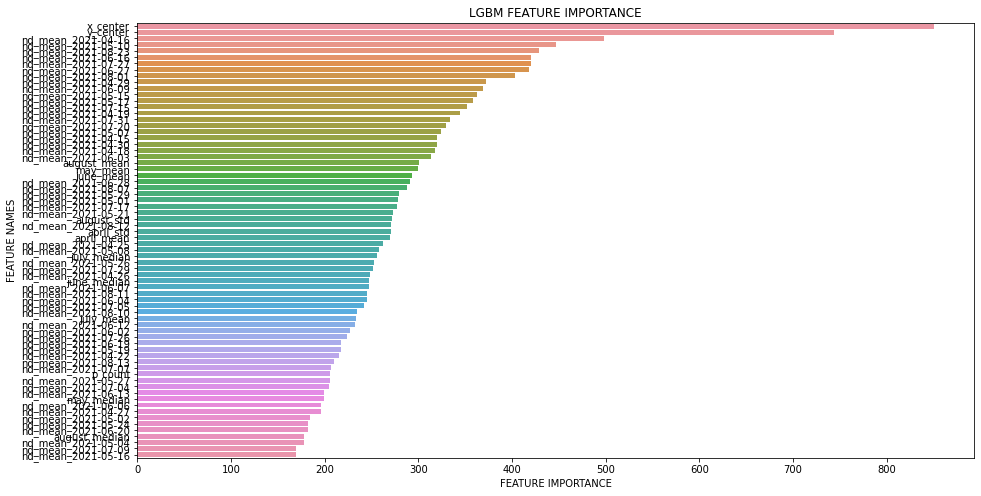

In [15]:
clf.fit(X, y)
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,
          'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data) 
    fi_df.sort_values(by=['feature_importance'],    
                     ascending=False,inplace=True)
    plt.figure(figsize=(15,8))
    sns.barplot(x=fi_df['feature_importance'], 
               y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    
plot_feature_importance(clf.feature_importances_, X.columns,'LGBM')

In [16]:
display(clf)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
sum_score = 0
for train_index, val_index in kfold.split(X, y):
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_val, y_val = X.iloc[val_index], y[val_index]
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    score = recall_score(y_val, pred, average=None)
    sum_score += sum(score / 7)
    display(score)
    print(sum(score / 7))
print(f'avg score: {sum_score / 3}\n')

LGBMClassifier(colsample_bytree=0.5, max_depth=12)

array([0.9338843 , 1.        , 0.96982759, 1.        , 0.94142259,
       1.        , 0.96396396])

0.9727283488333973


array([0.94628099, 1.        , 0.97844828, 0.99541284, 0.94166667,
       1.        , 0.94594595])

0.9725363891781307


array([0.9214876 , 0.9957265 , 0.97424893, 1.        , 0.92887029,
       1.        , 0.94594595])

0.9666113235576974
avg score: 0.9706253538564086



## Запись в файл

In [17]:
clf = clf.fit(X, y)
pred = clf.predict(X_test)
sub = pd.DataFrame({'id':test_id, 'crop':pred})
sub.to_csv('subRFE.csv', index = False)